# North American Online Car Auction Prediction 
#  

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load}

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usa-cers-dataset/USA_cars_datasets.csv


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import pickle
import time
import wordcloud
import seaborn as sns

pd.options.mode.chained_assignment = None
%matplotlib inline

# 1. EDA

1) Dataset Overview

In [5]:
# Read Data and Drop the First Column Of Artifact Of the .cvs File #
df = (pd.read_csv('/kaggle/input/usa-cers-dataset/USA_cars_datasets.csv').drop('Unnamed: 0', axis=1))
df.head()

,price,brand,model,year,title_status,mileage,color,vin,lot,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,new jersey,usa,10 days left
1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,tennessee,usa,6 days left
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,georgia,usa,2 days left
3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,virginia,usa,22 hours left
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,florida,usa,22 hours left


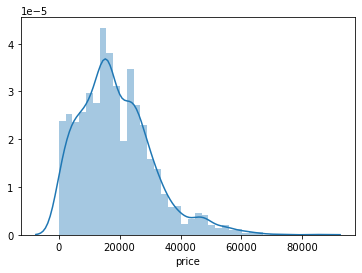

In [6]:
sns.distplot(df['price'], hist=True)

NameError: name 'df_owner_infor' is not defined

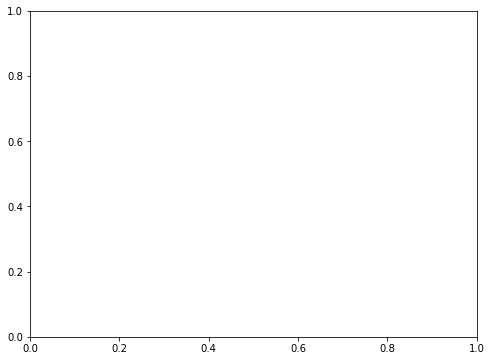

In [5]:
# Price Distribution #
fig = plt.figure(figsize=[8,6])
ax = plt.gca()
plt.bar(df_owner_infor.keys(), df_owner_infor.values(), edgecolor="black", color="coral")
for idx, key in enumerate(df_owner_infor.keys()):
    ax.annotate("{:>4s}".format(str(df_owner_infor[key])), (idx-0.3, df_owner_infor[key] + 200), fontsize=10)
plt.xticks(rotation="60", fontsize=10)
plt.tight_layout(pad=2)
plt.xlabel("Price", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Owner Number", size=16);
#plt.savefig("Owners_distribution.jpg", dpi=300);

In [7]:
# Drop Unnecessary Column #
df.drop(['vin'],axis=1,inplace=True)

In [8]:
# Convert Condition, a Categorical Feature to Numerical Feature:
def ConditionInHr(data, variable):
    '''
    "Convert Condition to hrs"
    '''    
    condition_hr=[]    
    for line in data[variable].tolist():
        if "hour" in line:
            condition_hr.append(int(line.split("hours")[0]))
        elif 'day' in line:
            condition_hr.append(int(line.split("days")[0])*24)
        elif 'minute' in line:
            condition_hr.append(int(line.split("minutes")[0])/60)
        elif "Listing Expired" in line:
            condition_hr.append(0)
    condition_in_hr=pd.Series(condition_hr) 
    return condition_in_hr 
df["condition"]=ConditionInHr(df,'condition')
df.describe()

,price,year,mileage,lot,condition
count,2499.000000,2499.000000,2.499000e+03,2.499000e+03,2499.000000
mean,18767.671469,2016.714286,5.229869e+04,1.676914e+08,54.788009
std,12116.094936,3.442656,5.970552e+04,2.038772e+05,61.136315
min,0.000000,1973.000000,0.000000e+00,1.593488e+08,0.000000
25%,10200.000000,2016.000000,2.146650e+04,1.676253e+08,21.000000
50%,16900.000000,2018.000000,3.536500e+04,1.677451e+08,48.000000
75%,25555.500000,2019.000000,6.347250e+04,1.677798e+08,48.000000
max,84900.000000,2020.000000,1.017936e+06,1.678055e+08,360.000000


In [9]:
# None Check #
print("None check:\n{}".format(",".join([df.isnull().columns[idx] + ":" + str(i) for idx, i in enumerate(df.isnull().sum())])))


None check:
price:0,brand:0,model:0,year:0,title_status:0,mileage:0,color:0,lot:0,state:0,country:0,condition:0


In [10]:
# Replace None with Median Price"
df['price'].replace(0,df['price'].median(),inplace=True)

2) Categorical Feature
 We will check if there is a trend for categorical feature

In [11]:
def getword(data, category):
    item = {}
    for line in data[category].tolist():
        line = [line]
        for w in line:
            if w not in item:
                item[w] = 1
            else:
                item[w] += 1
    
    item = {x:y for x, y in sorted(item.items(), key = lambda x: x[1], reverse = True)}
    
    return item
print("There are ",len(getword(df, "brand"))," brands.")
print("There are ",len(getword(df, "model"))," models.")
print("There are ",len(getword(df, "title_status"))," title_status.")
print("There are ",len(getword(df, "color")), " colors.")
print("There are ",len(getword(df, "state")), " states.")
print("There are ",len(getword(df, "country"))," countries.")

There are  28  brands.
There are  127  models.
There are  2  title_status.
There are  49  colors.
There are  44  states.
There are  2  countries.


In [2]:
sns.swarmplot("price", "title_status", data=df);
plt.show()

NameError: name 'sns' is not defined

In [12]:
brand=getword(df, "brand")
model=getword(df, "model")
color=getword(df, "color")
state=getword(df, "state")

#为什么是25000
high_price_df = df[df["price"] >= 25000]
#jennie不懂high_price_brand = {key:sum(high_price_df[key]) if key in brand.keys() else sum(high_price_df[key]) for key in brand}
high_price_brand=getword(high_price_df, "brand")
high_price_model=getword(high_price_df, "model")
high_price_color=getword(high_price_df, "color")
high_price_state=getword(high_price_df, "state")

In [13]:
def wordcloudplot(freq_dict):
    '''
    Draw wordcloud for categorical features based on freq_dict, freq_dict can be frequency or other variable numbers
    '''
    wc = wordcloud.WordCloud(background_color="white", max_font_size=60, max_words=60, random_state=0).generate_from_frequencies(freq_dict)
    plt.figure(figsize=[6,6])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off");

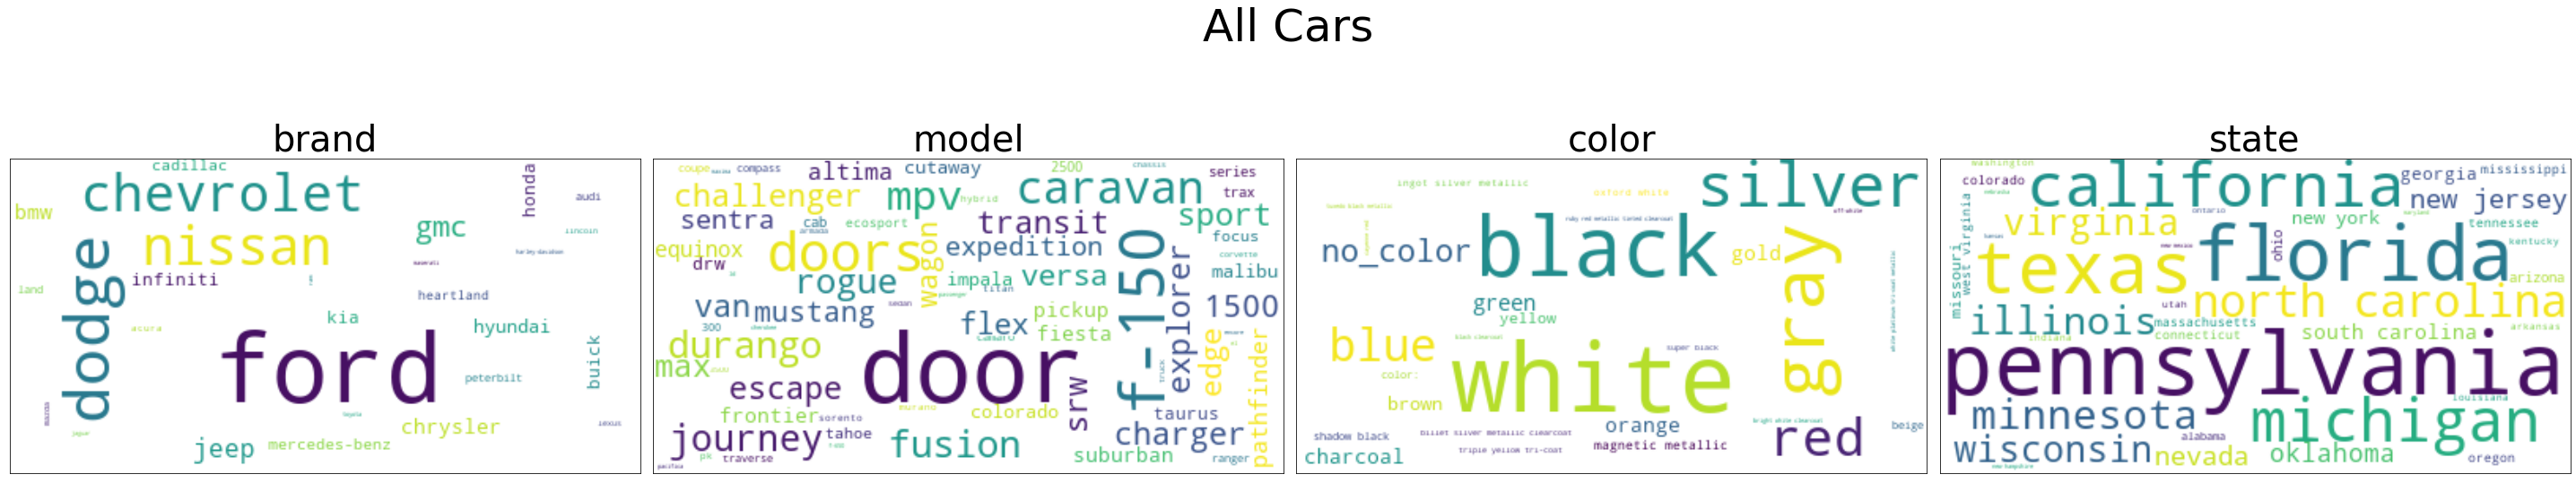

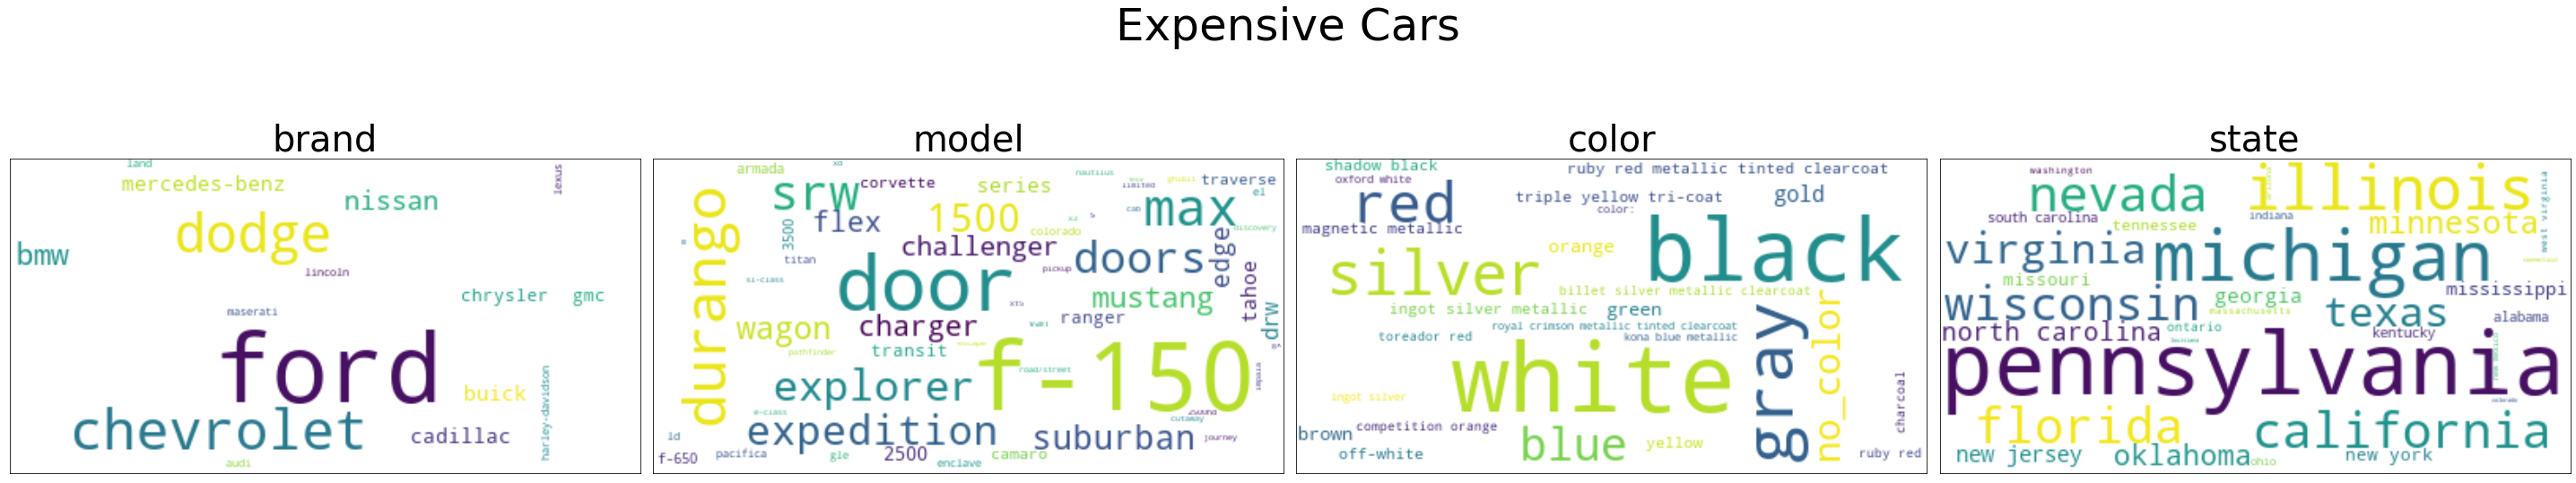

In [14]:
#把vcab都改掉
fig = plt.figure(figsize=[40,10])
fig.suptitle("All Cars", fontsize=50)
list_vcab = [brand, model, color, state]
titles = ["brand", "model", "color", "state"]
for i in range(1,5):
    ax = fig.add_subplot(1,4,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=60, random_state=0).generate_from_frequencies(list_vcab[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("on")
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    ax.set_title(titles[i-1], size=40)
plt.tight_layout()
plt.show();

# price higher than 25000$ #
fig = plt.figure(figsize=[40,10])
fig.suptitle("Expensive Cars", fontsize=50)
list_vcab = [high_price_brand, high_price_model, high_price_color, high_price_state]
titles = ["brand", "model", "color", "state"]
for i in range(1,5):
    ax = fig.add_subplot(1,4,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=60, random_state=0).generate_from_frequencies(list_vcab[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("on")
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    ax.set_title(titles[i-1], size=40)
plt.tight_layout()
plt.show();

3) Numerical Feature

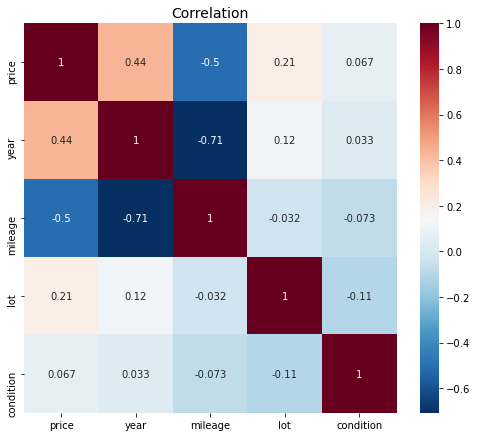

In [43]:
figure = plt.figure(figsize=[7,6])
ax = plt.gca()
sns.heatmap(df.corr(method="spearman"),cmap="RdBu_r", annot=True)
plt.tight_layout()
plt.title("Correlation", size=14);


* Price and year are poistively correlated.
* Price and mileage are negatively correlated.
* Price and lot are poistively correlated.
* No feature shows good correlation between price and condition.

# 2. Price Prediction 

1)Data pre-processing

In [13]:
df_est=df.copy()
df_est.drop(['lot'],axis=1)

,price,brand,model,year,title_status,mileage,color,state,country,condition
0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,new jersey,usa,240.0
1,2899,ford,se,2011,clean vehicle,190552.0,silver,tennessee,usa,144.0
2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,georgia,usa,48.0
3,25000,ford,door,2014,clean vehicle,64146.0,blue,virginia,usa,22.0
4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,florida,usa,22.0
...,...,...,...,...,...,...,...,...,...,...
2494,7800,nissan,versa,2019,clean vehicle,23609.0,red,california,usa,24.0
2495,9200,nissan,versa,2018,clean vehicle,34553.0,silver,florida,usa,21.0
2496,9200,nissan,versa,2018,clean vehicle,31594.0,silver,florida,usa,21.0
2497,9200,nissan,versa,2018,clean vehicle,32557.0,black,florida,usa,48.0


In [14]:
# Adopt Label Encoder for Categorical Features #
##I use Label Encoder here instead of One-Hot Encoder due to some features had large cardinality numbers which could generate too many features to the dataset if using One-Hot Encoding
cat_features = [cat for cat in df_est.select_dtypes('object')]
le=LabelEncoder()
for cat in cat_features:
    df_est[cat]=le.fit_transform(df_est[cat])


In [15]:
# Seprate the Target Set #
target=df_est["price"]
remainder=df_est.drop("price",axis=1)

# Split Dataset using 8:1:1 #  #不知道shuffle randomestate是什么#
remainder_train,remainder_test,target_train,target_test = train_test_split(remainder,target,test_size=0.10)
remainder_train,remainder_val,target_train,target_val = train_test_split(remainder_train,target_train,test_size=0.111)
train_set=pd.concat([remainder_train,target_train],axis=1)
test_set=pd.concat([remainder_test,target_test],axis=1)
val_set=pd.concat([remainder_val,target_test],axis=1)
print(remainder_train.shape,remainder_val.shape,remainder_test.shape)

(1999, 10) (250, 10) (250, 10)


In [64]:
# Scale Both Sets #
ss=StandardScaler()
remainder_train_scaled=pd.DataFrame(ss.fit_transform(remainder_train), columns=remainder_train.columns)
remainder_train_scaled.index=train_set.index
remainder_test_scaled=pd.DataFrame(ss.fit_transform(remainder_test), columns=remainder_test.columns)
remainder_test_scaled.index=test_set.index

In [48]:
# Feature Selection #
...

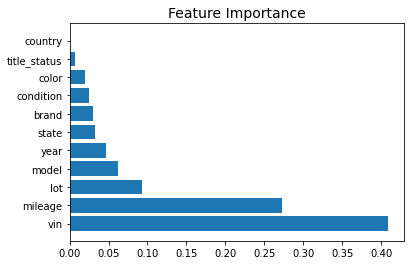

0.7092400960821522
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [18]:
rfr=RandomForestRegressor()
rfr.fit(remainder_train,target_train)
feature_imp = pd.Series(rfr.feature_importances_, index=remainder_train.columns)
plt.barh(feature_imp.nlargest(remainder_train.shape[1]).index,feature_imp.nlargest(remainder_train.shape[1]))
plt.title("Feature Importance", size=14)
plt.show()
print(r2_score(target_test,rfr.predict(remainder_test)))
print(rfr.get_params())

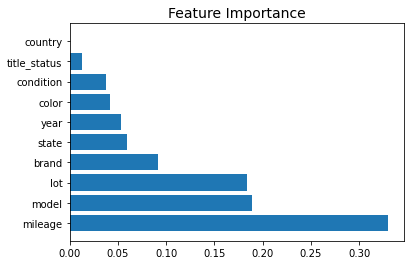

In [72]:
rfr=RandomForestRegressor()
rfr.fit(remainder_train_scaled,target_train)
feature_imp = pd.Series(rfr.feature_importances_, index=remainder_train_scaled.columns)
plt.barh(feature_imp.nlargest(remainder_train_scaled.shape[1]).index,feature_imp.nlargest(remainder_train_scaled.shape[1]))
plt.title("Feature Importance", size=14)
plt.show()

In [17]:
# Drop Zero Feature Country #
remainder_train.drop("country",axis=1)
remainder_test.drop("country",axis=1)
remainder_val.drop("country",axis=1)

rfr=RandomForestRegressor()
rfr.fit(remainder_train,target_train)


RandomForestRegressor()

2) Hyperparameter Tuning for RandomForestRegressor

In [22]:
# Random Hyperparameter Grid #
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the Random Grid to Set Best Hyperparameters #
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# (search across 100 different combinations, 3 fold cross validation, and use all available cores)
rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=40, n_jobs = -1)
# Fit the random search model
rfr_random.fit(remainder_train, target_train)
rfr_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.4min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [58]:

rfr_random.best_estimator_.fit(remainder_train,target_train)
r2_score(target_test,rfr_random.best_estimator_.predict(remainder_test))
print("The r2 score is", r2_score(target_test,rfr_random.best_estimator_.predict(remainder_test)),",", "improves", 100*(r2_score(target_test,rfr_random.best_estimator_.predict(remainder_test))-r2_score(target_test,rfr.predict(remainder_test)))/r2_score(target_test,rfr.predict(remainder_test)),"%")

The r2 score is 0.7238842424984386 , improves 1.9412297048746092 %


In [24]:
rfr_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt',
                      n_estimators=200)

In [64]:
# Grid Search with Cross Validation#

# Create the parameter grid based on best model for random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [0, 1, 2],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 150, 200, 250, 300]}


# Instantiate the grid search model
rfr_grid_search = GridSearchCV(estimator = rfr, param_grid=param_grid, cv = 3, n_jobs = -1, verbose = 2)
rfr_grid_search.fit(remainder_train,target_train)
rfr_grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.6min finished


{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [67]:
rfr_grid_search.best_estimator_.fit(remainder_train,target_train)
r2_score(target_test,rfr_grid_search.best_estimator_.predict(remainder_test))
print("The r2 score is", r2_score(target_test,rfr_grid_search.best_estimator_.predict(remainder_test)),",", "improves", 100*(r2_score(target_test,rfr_grid_search.best_estimator_.predict(remainder_test))-r2_score(target_test,rfr_random.best_estimator_.predict(remainder_test)))/r2_score(target_test,rfr_random.best_estimator_.predict(remainder_test)),"%")

The r2 score is 0.7267548121993881 , improves 0.3965509307181315 %


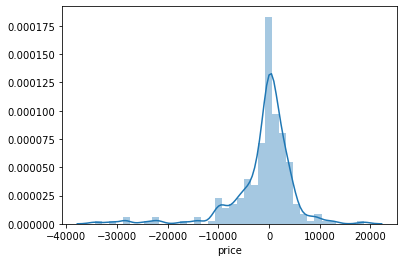

In [74]:
sns.distplot(rfr_grid_search.best_estimator_.predict(remainder_test)-target_test)


3) XGBRegressor

In [58]:
xgb=XGBRegressor()
xgb.fit(remainder_train,target_train)
print(r2_score(y_pred=xgb.predict(remainder_test),y_true=target_test))

0.712175782111778


In [59]:
print(xgb.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)>


In [61]:
xgb=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1,monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
#xgb.fit(remainder_train,target_train, eval_set=[(remainder_val, target_val)])
xgb.fit(remainder_train,target_train, eval_set=[(remainder_val, target_val)],early_stopping_rounds=50,eval_metric=["rmse"])
print(r2_score(y_pred=xgb.predict(remainder_test),y_true=target_test))
print(xgb.get_params)

[0]	validation_0-rmse:16357.55957
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:12761.25391
[2]	validation_0-rmse:10170.24414
[3]	validation_0-rmse:8812.41894
[4]	validation_0-rmse:7989.79395
[5]	validation_0-rmse:7455.04541
[6]	validation_0-rmse:7197.06445
[7]	validation_0-rmse:7044.10840
[8]	validation_0-rmse:6958.54053
[9]	validation_0-rmse:6820.07715
[10]	validation_0-rmse:6723.86914
[11]	validation_0-rmse:6625.56494
[12]	validation_0-rmse:6607.04736
[13]	validation_0-rmse:6543.56250
[14]	validation_0-rmse:6528.68457
[15]	validation_0-rmse:6558.24219
[16]	validation_0-rmse:6583.33105
[17]	validation_0-rmse:6565.90625
[18]	validation_0-rmse:6565.13086
[19]	validation_0-rmse:6529.32617
[20]	validation_0-rmse:6482.45654
[21]	validation_0-rmse:6494.48486
[22]	validation_0-rmse:6445.84766
[23]	validation_0-rmse:6568.47363
[24]	validation_0-rmse:6592.57715
[25]	validation_0-rmse:6545.01074
[26]	validation_0-rmse:6552.50781
[27]	validation_0-rmse:6